# Improving dollar-cost averaging strategy by dynamically prioritizing stocks experiencing significant price drops

***Motivation:*** *I am transitioning to a career in quantitative finance. I developed this project after reading Burton Malkiel's* **A Random Walk Down Wall Street**. *I really enjoyed the book and sparked some curiosity to build a data pipeline and do some of my own analysis. DCA is so simple and it was fun to think through it.*

## 1. Introduction

### *What is Dollar-Cost Averaging?*

Dollar-Cost averaging (DCA) is a simple investment strategy in which a fixed dollar amount is invested at regular intervals. In practice employing the DCA strategy can reduce the average purchase price of shares. The strategy works because as stock prices fluctuate the fixed investment amount purchases more shares when the price is low and fewer shares when prices rise. In addition, I developed the Adaptive Price-Drop (APD) strategy, which allocates portfolio weights based on percentile-based price changes across assets.

**Let's start with an example of the DCA strategy with a single stock.**

In [1]:
# Date imports
import datetime
from dateutil.relativedelta import relativedelta
# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()

%matplotlib inline

### Code Structure

DCA is a long-term investment strategy and is frequently implemented in 401(k) and other retirement savings plans. The strategy works well when the investor invests a percentage of a paycheck. In order develop and backtest investment strategies with real stock prices I developed the Equities Toolkit. The `equities_toolkit.py` file contains the core classes and functionality.

- **Load and process stock data** with the `Stock` class, which retrieves historical data, adjusts for inflation, and prepares individual assets for analysis.
- **Combine stocks into a portfolio** using the `Stocks_Composite` class, creating a custom market index with weighted components for diversified investing.
- **Simulate investor behavior** with the `Investor` class, including periodic cash flows, total invested calculation, and investment tracking.
- **Apply the Adaptive Price-Drop strategy** through the `Adaptive_Price_Drop` class, which automatically adjusts investments based on the relative price change of each stock.

### Let's simulate the DCA strategy purchasing `$500` worth of $\color{red}{\text{Exxon Mobil}}$ (XOM) shares every 2 weeks for a period of 2 years.

In [2]:
# Import the equities_toolkit.py
import equities_toolkit as etk

The Equities Toolkit uses the `yfinance` package to retrieve historical stock prices. The `Stock` class from the Equities Toolkit adds functionality to the `yfinance` `ticker` object. Let's create the XOM object and download the price history for the previous 2 years.

In [3]:
xom = etk.Stock('XOM')

In [4]:
# For consistancy I'm setting the end date to 10/17/2024
end_date=datetime.datetime(2024, 10, 17).date()
start_date = end + relativedelta(weeks=-104)  # Two years back
xom.download_history(start=start, end=end)

In [5]:
xom.price_history.head()

,Date,Close,Volume,Dividends,Inflation_Adj
0,2022-10-17,97.327332,40463100,0.00,103.747737
1,2022-10-24,101.777206,96511200,0.00,108.491158
2,2022-10-31,103.257439,103914300,0.00,110.069037
3,2022-11-07,104.765259,90857400,0.00,111.789234
4,2022-11-14,103.045975,81664000,0.91,109.954680


Since this example only purchases a shares in XOM we can calculate the strategy **manually**. I am going to allow the partial shares which aren't available from all retail brokerage firms. Yahoo Finance adjusts their closing prices for US stocks dividends and splits, so we will just drop them here. I am also not analyzing `Volume`, so I'll drop that as well.

In [6]:
# Clean up the data
xom.price_history.drop(columns=['Volume', 'Dividends'], inplace=True)

In [7]:
xom.price_history.head()

,Date,Close,Inflation_Adj
0,2022-10-17,97.327332,103.747737
1,2022-10-24,101.777206,108.491158
2,2022-10-31,103.257439,110.069037
3,2022-11-07,104.765259,111.789234
4,2022-11-14,103.045975,109.954680


In [8]:
# Select weeks of purchases
xom_dca = xom.price_history.loc[::2].copy() 

In [9]:
xom_dca['Cost'] = 500.0 # Set fixed investment amount

In [10]:
xom_dca['Cum_Cost'] = xom_dca.Cost.cumsum() # Calculate cummulative cost 

In [11]:
xom_dca.head()

,Date,Close,Inflation_Adj,Cost,Cum_Cost
0,2022-10-17,97.327332,103.747737,500.0,500.0
2,2022-10-31,103.257439,110.069037,500.0,1000.0
4,2022-11-14,103.045975,109.954680,500.0,1500.0
6,2022-11-28,101.818031,108.644410,500.0,2000.0
8,2022-12-12,97.035744,103.860355,500.0,2500.0


In [12]:
xom_dca['Shares'] = xom_dca.Cost / xom_dca.Close # Calculate the number of shares
xom_dca['Cum_Shares'] = xom_dca.Shares.cumsum() # Calculate the cummulative shares purchased

In [13]:
xom_dca.head()

,Date,Close,Inflation_Adj,Cost,Cum_Cost,Shares,Cum_Shares
0,2022-10-17,97.327332,103.747737,500.0,500.0,5.137303,5.137303
2,2022-10-31,103.257439,110.069037,500.0,1000.0,4.842266,9.979569
4,2022-11-14,103.045975,109.954680,500.0,1500.0,4.852203,14.831772
6,2022-11-28,101.818031,108.644410,500.0,2000.0,4.910722,19.742494
8,2022-12-12,97.035744,103.860355,500.0,2500.0,5.152740,24.895234


In [14]:
# Calcuate the total value of the portfolio throughout time
xom_dca['value']= xom_dca.apply(lambda x: x.Close * x.Cum_Shares, axis=1)

In [15]:
total_shares = xom_dca.Cum_Shares.max()  # The final total amount to shares

**The objective of using the DCA strategy is to lower the average purchase price per share. We will compare it to the average share price over the same period.**

In [16]:
# calculate the weighted average and standard deviation
avg_pps, std_pps = etk.weighted_avg_and_std(xom_dca.Close, xom_dca.Shares)
print(avg_pps, std_pps)

104.96450014458942 6.8452197758196185


In [17]:
xom.price_history.Close.describe()

count    105.000000
mean     105.227318
std        6.906861
min       92.920822
25%       99.419067
50%      103.727219
75%      110.559044
max      122.714973
Name: Close, dtype: float64

In [19]:
# Calculate the percent difference in the mean share price
percent_diff = ((106.7735991853189 - 107.040947) / 107.040947 ) * 100
percent_diff

-0.24976219117446907

In [18]:
# Calculate the total gain/loss
dca_gain = ((xom_dca.value.iloc[-1] / xom_dca.Cum_Cost.iloc[-1]) -1) * 100
print(f"Total Cost: ${xom_dca.Cum_Cost.iloc[-1]} Value: ${round(xom_dca.value.iloc[-1],2)} g/l: {round(dca_gain,2)}%")

Total Cost: $26500.0 Value: $29869.51 g/l: 12.72%


In [21]:
# Save the data for tableau
#xom.to_csv('xom_20221017-20241014.txt',index_label='week', sep=' ')
#xom_dca.to_csv('xom_dca_20221017-20241014.txt', index_label='week', sep=' ')

### *Let's take a look at the distribution of the Exxon weekly returns*

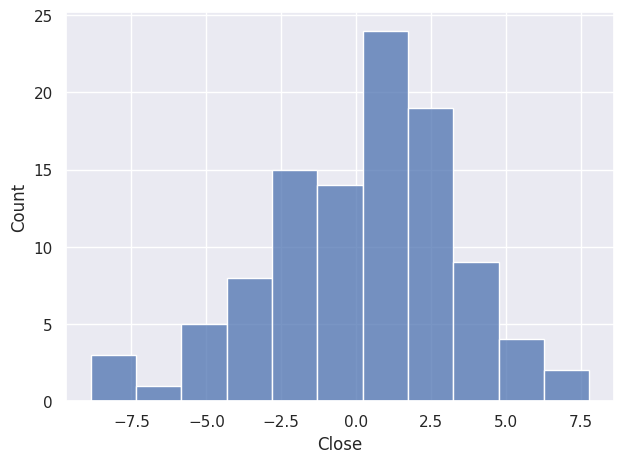

In [19]:
sns.histplot(xom.price_history.Close.pct_change()*100)
plt.tight_layout()
plt.show()

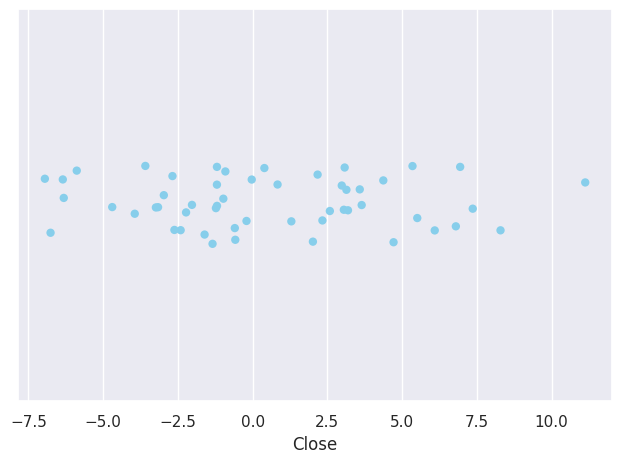

In [20]:
# Let's also look at the weekly price change values on a strip plot
# Create the 1D scatter plot using stripplot
sns.stripplot(x=xom_dca.Close.pct_change()*100, color='skyblue', size=6)
plt.tight_layout()
plt.show()

**The historical weekly returns can be used to estimate the growth rate as well as the uncertainty in the growth rate. This distribution more or less appears to be normal and homogeneously distributed that suggests that the market conditions remained relatively stable during this sample period.**

In [21]:
# Finally, let's look at the summary
xom.price_history.Close.pct_change().describe()*100

count    10400.000000
mean         0.237284
std          3.145469
min         -8.853543
25%         -1.611466
50%          0.810896
75%          2.034515
max          7.779324
Name: Close, dtype: float64

The DCA strategy is commonly used in conjunction with a buy and hold objective that can span decades. Over this relatively short two year window it did reduce the average price per share. The mean purchase price was reduced by -0.249%, obviously not a large reduction. The DCA strategy has some vulnerabilities, particularly if the price 'runs away' in either positive or negative direction the average purchase price will not be reduced during those market movements. 

### *Let's visualize the XOM share price over the period we applied the DCA strategy.*

In [22]:
# Set marker sizes
xom_dca['mrkr_size'] = 10
xom_dca.loc[[48,50,84,86], 'mrkr_size'] = 50 # points to highlight

In [23]:
# Annotation text from the eg_purchases [FIX WITH fstrings]
#annotation_txt = [' 4.5 Shares', ' 4.8 Shares', '4.3 Shares', '4.6 Shares']

In [24]:
# Save for tableau
# eg_purchase.to_csv('eg_purchase_xom_dca.txt', index_label='week', sep=' ')

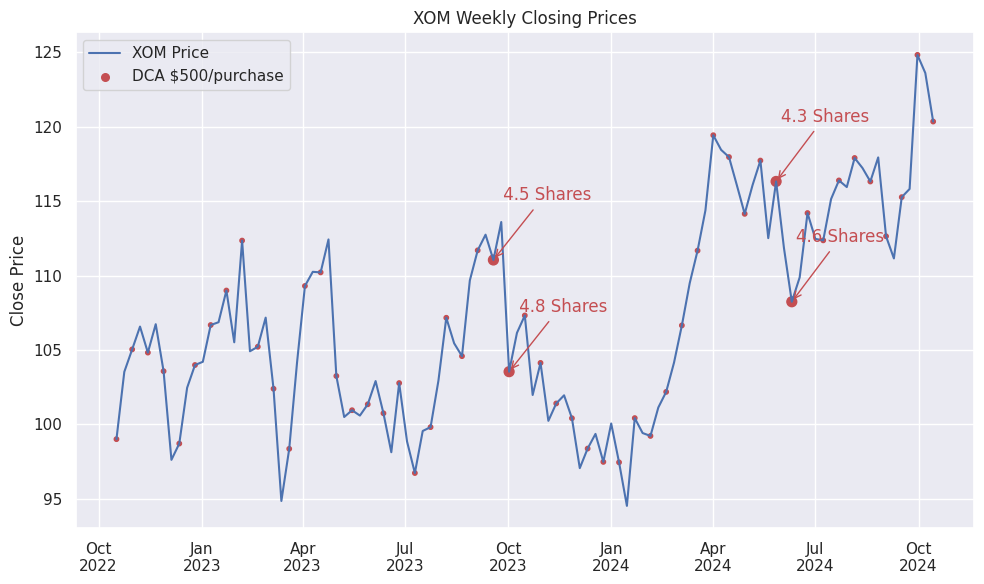

In [64]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(xom.price_history['Date'], xom.price_history['Close'], label='XOM Price', color='C0')
ax.scatter(xom_dca['Date'], xom_dca['Close'], xom_dca['mrkr_size'], label='DCA $500/purchase', color='C3', marker='o')

# Formatting the x-axis to show quarter ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))  # Quarterly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Show month and year

# Add annotation
arrows = {'arrowstyle':'->', 'color': 'C3'}

for i in range(len(annotation_txt)):
    x = eg_purchase.Date.iloc[i]
    y = eg_purchase.Close.iloc[i]
    ax.annotate(annotation_txt[i], (x, y), xytext=(mdates.date2num(x)+4, y+4), arrowprops=arrows, color='C3')

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Close Price')
ax.set_title('XOM Weekly Closing Prices')

# Add grid and legend
ax.grid(True)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

*There is some price volatility distributed around the mean value of $107.04 and from week to week offering some opportunities for DCA to be effective. The period of price stabilization after April 2024 likely increased the mean purchase price. Strategies based around the volatility of returns can be somewhat hit or miss because they not only depends on the distribution of returns, but the also the time sequence. To get any sort of estimate on its effectiveness we would have to simulate the strategy across many timelines. I will try to do it in the future using Monte Carlo sampling.*

Next, let's see how effective the DCA strategy is when applied to a slightly boarder stock index.

## 2. Five Blue-Chip Stock Index

DCA is commonly applied when investing in stock indices or exchange traded funds (ETFs) that track popular indices. ETFs provide easy diversification and can group securities with desirable characteristics together. ETFs are great for passive investors wishing to 'buy the market average'. We are going going to evaluate the application of the investment strategies to an index weighted by the market capitalization (market cap) of 5 blue-chip stocks. We'll begin by creating a `etk.Stocks_Composite` object to contain the historical prices.

**Blue-chip stocks are large established companies that have a market cap of $10B or more. Blue-chip companies are typically industry leaders and have a lower risk of collapse. However, blue-chip stocks tend to grow slowly because of their size and their stock prices can be expensive. Here, I selected only 5 stocks to include in the index because there is enough variables to give an intuition about how an index might evolve without making the quantity of data overwhelming. The following is a summary of the selected stocks.**

| Company | Symbol | Sector | Market Cap (Jan 2, 2025)|
| :-      | :-     | :-     | :-                          |
| Microsoft | MSFT | Technology | \$3.112 T |
| Exxon Mobil | XOM | Energy | \$471.638 B |
| Abbvie | ABBV | Healthcare | \$317.096 B |
| AT&T | T | Telecommunications | \$163.812 B |
| 3M | MMM | Industrials | \$70.629 B |

**Let's create the index object and download the stock prices for the period from 2018-1-1 to 2024-12-31. The adaptive-price-drop strategy compiles statistics on the weekly price changes in a trailing window. We'll analyze a 5 year period, but download a 7 year period anticipating the need for the trailing window data later.**

In [4]:
# Define the stocks to include 
tickers = ['MSFT', 'ABBV', 'XOM', 'T', 'MMM']
colors = ['C2', 'C1', 'C0', 'C3', 'C4'] # Assign colors for viz

In [5]:
# Set dates of stock prices
end = datetime.datetime(2024, 12, 31)
start = datetime.datetime(2018, 1, 1) 

In [6]:
bc5 = etk.Stocks_Composite(tickers, start=start, end=end, interval='1wk')

Making a quick plot to check the data.

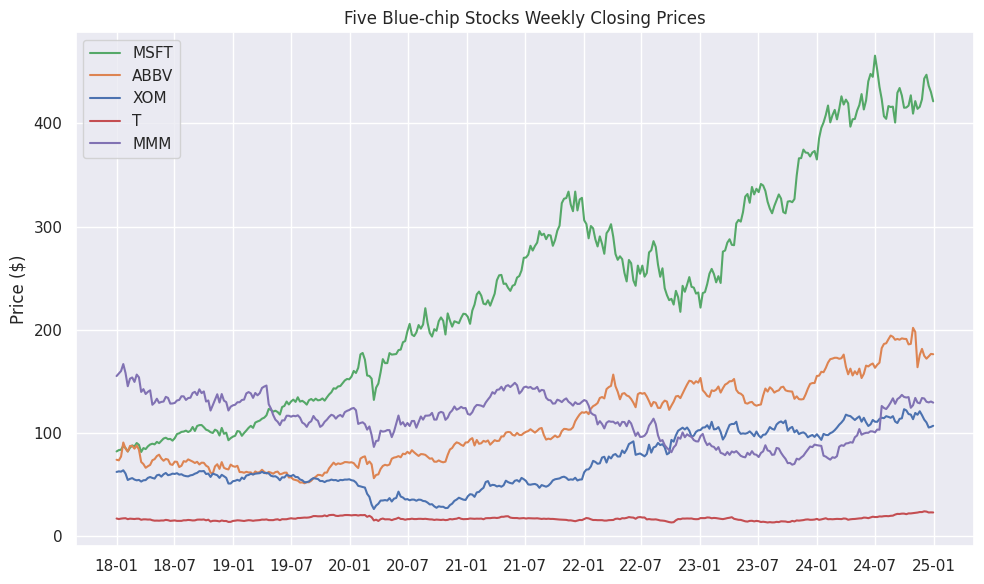

In [7]:
# Viz of the bc5 time series
fig, ax = plt.subplots(figsize=(10,6))

for i in range(len(tickers)):
    date = bc5.stocks[tickers[i]].price_history.Date
    ax.plot(date, bc5.stocks[tickers[i]].price_history.Close, label=tickers[i], color=colors[i])

# Formatting the x-axis to show semi-annual ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))  # Quarterly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))  # Show month and year

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Price ($)')
ax.set_title('Five Blue-chip Stocks Weekly Closing Prices')

# Add grid and legend
ax.grid(True)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [8]:
# the market cap is retrieved by the yfinance ticker object and used to determine the weights
bc5_weights = pd.DataFrame(bc5.weights, index=[0])

In [9]:
bc5_weights

,MSFT,ABBV,XOM,T,MMM
0,0.737914,0.082833,0.114512,0.045131,0.019609


In [10]:
bc5_weights.loc[0] =  round(bc5_weights.loc[0] * 100, 2)

In [11]:
bc5_weights

,MSFT,ABBV,XOM,T,MMM
0,73.79,8.28,11.45,4.51,1.96


**MSFT is 73.79% of the market value, not too surprising.**

In [12]:
bc5_weights.to_csv('mcap_weights_20250215.txt', sep=' ', index=False)

Now, lets plot the `bc5` index. The `Stock` object uses the Consumer Price Index data to adjust the dollars to a common date. The `Stock` object uses the final date for the adjustment. We'll include it here on the plot.

In [13]:
# get the inflation adjustment date
inf_adj_date = bc5.stocks['MSFT'].inflation_adjusted_date
inf_adj_date

datetime.datetime(2024, 12, 31, 0, 0)

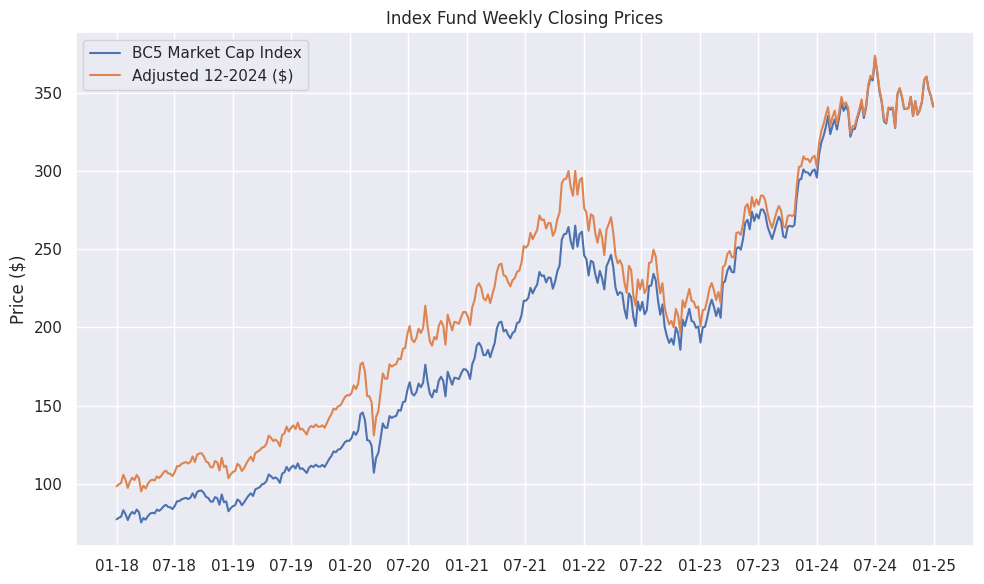

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(bc5.index.Date, bc5.index.Index, label='BC5 Market Cap Index', color='C0')
ax.plot(bc5.index.Date, bc5.index.Index_Adj, label=f'Adjusted {inf_adj_date.month}-{inf_adj_date.year} ($)', color='C1')

# Formatting the x-axis to show quarter ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))  # Quarterly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))  # Show month and year

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Price ($)')
ax.set_title('Index Fund Weekly Closing Prices')

# Add grid and legend
ax.grid(True)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

Let's calculate the inflation adjusted weekly returns and save the data to reference later.

In [17]:
tickers

['MSFT', 'ABBV', 'XOM', 'T', 'MMM']

In [23]:
# should get a more systematic way of saving
bc5.stocks['MSFT'].price_history['inf_adj_pct_change'] = bc5.stocks['MSFT'].price_history.Inflation_Adj.pct_change()*100
bc5.stocks['ABBV'].price_history['inf_adj_pct_change'] = bc5.stocks['ABBV'].price_history.Inflation_Adj.pct_change()*100
bc5.stocks['XOM'].price_history['inf_adj_pct_change'] = bc5.stocks['XOM'].price_history.Inflation_Adj.pct_change()*100
bc5.stocks['T'].price_history['inf_adj_pct_change'] = bc5.stocks['T'].price_history.Inflation_Adj.pct_change()*100
bc5.stocks['MMM'].price_history['inf_adj_pct_change'] = bc5.stocks['MMM'].price_history.Inflation_Adj.pct_change()*100

In [24]:
bc5.stocks['MSFT'].price_history.head()

,Date,Close,Volume,Dividends,Inflation_Adj,inf_adj_pct_change
0,2018-01-01,81.708900,93864300,0.0,104.038608,NaN
1,2018-01-08,83.015297,102329900,0.0,105.702021,1.598842
2,2018-01-15,83.385887,123255600,0.0,106.173887,0.446412
3,2018-01-22,87.147514,135847300,0.0,110.963506,4.511108
4,2018-01-29,85.035072,214057000,0.0,108.273768,-2.423984


In [25]:
bc5.stocks['MSFT'].price_history.columns

Index(['Date', 'Close', 'Volume', 'Dividends', 'Inflation_Adj',
       'inf_adj_pct_change'],
      dtype='object')

In [26]:
# Columns to save
cols = ['Date', 'Close', 'Inflation_Adj', 'inf_adj_pct_change']

In [28]:
bc5.index.to_csv('bc5_index_20180101-20241231.txt', index_label='week', sep=' ')
bc5.stocks['MSFT'].price_history.to_csv('MSFT_20180101-20241231.txt', index_label='week', sep=' ', columns=cols)
bc5.stocks['ABBV'].price_history.to_csv('ABBV_20180101-20241231.txt', index_label='week', sep=' ', columns=cols)
bc5.stocks['XOM'].price_history.to_csv('XOM_20180101-20241231.txt', index_label='week', sep=' ', columns=cols)
bc5.stocks['T'].price_history.to_csv('T_20180101-20241231.txt', index_label='week', sep=' ', columns=cols)
bc5.stocks['MMM'].price_history.to_csv('MMM_20180101-20241231.txt', index_label='week', sep=' ', columns=cols)

In [15]:
sc.index.to_csv('bc5_index_20201026-20241021.txt', index_label='week', sep=' ')

## 3. Application of DCA to the 5 blue-chip stock index

Now that we have created `bc5` index, we can apply the DCA strategy. As we did previously, we will set the amount and frequency of `$500` and `2 weeks`, respectively. We need to setup the date range to apply the strategies.

In [29]:
# Apply over the 5 year period between Jan 2020 -> December 2024
dates = pd.to_datetime(bc5.index.Date)
start_ndx = dates[dates.dt.year == 2020].index[0]
end_ndx = dates.index[-1]
end_date = dates.iloc[-1].date()
start_date = dates.iloc[start_ndx].date()
simulated_dates = bc5.index.Date.iloc[start_ndx:]

In [30]:
start_date

datetime.date(2020, 1, 6)

Now we'll create the DCA strategy object.

In [31]:
dca_bc5_index = etk.Index_Fund(bc5, cash=500.0, cashflow=500.0)
dca_bc5_index.set_cashflow_start(simulated_dates.iloc[0])

In [32]:
dca_bc5_index.partial_shares

True

In [35]:
# loop through the simulated dates
for d in simulated_dates:
    dca_bc5_index.invest(d)

In [36]:
dca_bc5_index.purchases

[{'Date': datetime.date(2020, 1, 6),
  'MSFT': (2.3908672852734107, 154.32),
  'ABBV': (0.5817071220263458, 71.2),
  'XOM': (1.0648496587962857, 53.77),
  'T': (1.1473657559697976, 19.67),
  'MMM': (0.07953054153450607, 123.28),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2020, 1, 13), 'Action': 'Price Out'},
 {'Date': datetime.date(2020, 1, 20),
  'MSFT': (2.3372672612363132, 157.86),
  'ABBV': (0.6118772537605146, 67.69),
  'XOM': (1.110128433333915, 51.58),
  'T': (1.1293509755816311, 19.98),
  'MMM': (0.0805662669678135, 121.7),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2020, 1, 27), 'Action': 'Price Out'},
 {'Date': datetime.date(2020, 2, 3),
  'MSFT': (2.097680519256863, 175.89),
  'ABBV': (0.5538653896180951, 74.78),
  'XOM': (1.1977176551771627, 47.8),
  'T': (1.1308193583627466, 19.96),
  'MMM': (0.0896606728346046, 109.35),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2020, 2, 10), 'Action': 'Price Out'},
 {'Date': datetime.date(2020, 2, 17),
  'MSFT': (2.1

Clean up the purchase history.

In [40]:
dca_bc5_purchases_df = pd.DataFrame(dca_bc5_index.purchases)
dca_bc5_purchases_df_clean = dca_bc5_purchases_df.dropna()
dca_bc5_purchases_df_clean = etk.split_shares_prices(dca_bc5_purchases_df_clean, tickers)

In [41]:
dca_bc5_purchases_df_clean.head()

,Date,Action,MSFT_shares,MSFT_price,ABBV_shares,ABBV_price,XOM_shares,XOM_price,T_shares,T_price,MMM_shares,MMM_price
0,2020-01-06,Buy Index,2.390867,154.32,0.581707,71.20,1.064850,53.77,1.147366,19.67,0.079531,123.28
2,2020-01-20,Buy Index,2.337267,157.86,0.611877,67.69,1.110128,51.58,1.129351,19.98,0.080566,121.70
4,2020-02-03,Buy Index,2.097681,175.89,0.553865,74.78,1.197718,47.80,1.130819,19.96,0.089661,109.35
6,2020-02-17,Buy Index,2.159934,170.82,0.538292,76.94,1.227494,46.64,1.127886,20.01,0.090640,108.17
8,2020-03-02,Buy Index,2.380961,154.96,0.575504,71.97,1.521948,37.62,1.174183,19.22,0.092575,105.91


In [42]:
dca_bc5_avg_std = {}

In [43]:
dca_bc5_avg_std['msft_avg'], dca_bc5_avg_std['msft_std'] = etk.weighted_avg_and_std(dca_bc5_purchases_df_clean.MSFT_price, dca_bc5_purchases_df_clean.MSFT_shares)
dca_bc5_avg_std['abbv_avg'], dca_bc5_avg_std['abbv_std'] = etk.weighted_avg_and_std(dca_bc5_purchases_df_clean.ABBV_price, dca_bc5_purchases_df_clean.ABBV_shares)
dca_bc5_avg_std['xom_avg'], dca_bc5_avg_std['xom_std'] = etk.weighted_avg_and_std(dca_bc5_purchases_df_clean.XOM_price, dca_bc5_purchases_df_clean.XOM_shares)
dca_bc5_avg_std['t_avg'], dca_bc5_avg_std['t_std'] = etk.weighted_avg_and_std(dca_bc5_purchases_df_clean.T_price, dca_bc5_purchases_df_clean.T_shares)
dca_bc5_avg_std['mmm_avg'], dca_bc5_avg_std['mmm_std'] = etk.weighted_avg_and_std(dca_bc5_purchases_df_clean.MMM_price, dca_bc5_purchases_df_clean.MMM_shares)


In [44]:
dca_bc5_avg_std

{'msft_avg': 266.7438508190599,
 'msft_std': 79.2496158331679,
 'abbv_avg': 113.36860397161226,
 'abbv_std': 35.14855522304171,
 'xom_avg': 62.34638024098009,
 'xom_std': 29.746467330393077,
 't_avg': 16.310474967476218,
 't_std': 1.9915857897570908,
 'mmm_avg': 103.3790514720678,
 'mmm_std': 21.044979668053262}

In [50]:
dca_bc5_purchases_tuple_df = pd.DataFrame(dca_bc5_index.purchases)
dca_bc5_purchases_tuple_df_clean = dca_bc5_purchases_df.dropna()
dca_bc5_purchases_tuple_df_clean.head()

,Date,MSFT,ABBV,XOM,T,MMM,Action
0,2020-01-06,"(2.3908672852734107, 154.32)","(0.5817071220263458, 71.2)","(1.0648496587962857, 53.77)","(1.1473657559697976, 19.67)","(0.07953054153450607, 123.28)",Buy Index
2,2020-01-20,"(2.3372672612363132, 157.86)","(0.6118772537605146, 67.69)","(1.110128433333915, 51.58)","(1.1293509755816311, 19.98)","(0.0805662669678135, 121.7)",Buy Index
4,2020-02-03,"(2.097680519256863, 175.89)","(0.5538653896180951, 74.78)","(1.1977176551771627, 47.8)","(1.1308193583627466, 19.96)","(0.0896606728346046, 109.35)",Buy Index
6,2020-02-17,"(2.159933695513839, 170.82)","(0.5382923727794664, 76.94)","(1.2274935670574174, 46.64)","(1.1278860787035454, 20.01)","(0.09063961165478185, 108.17)",Buy Index
8,2020-03-02,"(2.380960616934985, 154.96)","(0.575503607883788, 71.97)","(1.5219476007654944, 37.62)","(1.174183384177571, 19.22)","(0.09257451300748212, 105.91)",Buy Index


In [47]:
final_prices = bc5.get_prices(end_date)
final_prices

{'MSFT': 421.5,
 'ABBV': 176.0399169921875,
 'XOM': 106.61634826660156,
 'T': 22.48460578918457,
 'MMM': 129.08999633789062}

In [51]:
dca_bc5_cost_gain = etk.calc_cost_gains(dca_bc5_purchases_tuple_df_clean, tickers, final_prices)

In [52]:
dca_bc5_cost_gain.head()

,MSFT_cost,MSFT_gl,ABBV_cost,ABBV_gl,XOM_cost,XOM_gl,T_cost,T_gl,MMM_cost,MMM_gl
0,368.958639,638.791921,41.417547,60.986126,57.256966,56.273416,22.568684,3.229382,9.804525,0.462072
2,368.961010,616.197141,41.417971,66.296850,57.260425,61.097415,22.564432,2.828579,9.804915,0.595384
4,368.961027,515.211312,41.418054,56.084363,57.250904,70.445379,22.571154,2.854873,9.804395,1.769901
6,368.959874,541.452179,41.416215,53.344729,57.250300,73.620582,22.569000,2.791073,9.804487,1.896180
8,368.953657,634.621243,41.418995,59.892613,57.255669,105.008827,22.567805,3.833246,9.804567,2.145877


In [55]:
dca_bc5_gl = dca_bc5_cost_gain.apply(np.sum, axis=0).to_dict()

In [61]:
dca_bc5_index.calculate_total_invested()

In [62]:
dca_bc5_index.total_invested

65500.06

## Apply Adaptive Price Drop strategy to the 5 blue-chip stock index

In [69]:
apd_bc5_index = etk.Adaptive_Price_Drop(bc5, cash=500.0, cashflow=500.0)
apd_bc5_index.set_cashflow_start(simulated_dates.iloc[0])
apd_bc5_index.set_window(100)

In [70]:
apd_bc5_index.partial_shares

True

In [58]:
# loop through the simulated dates
for d in simulated_dates:
    apd_bc5_index.apd_invest(d)

In [59]:
apd_bc5_index.purchases

[{'Date': datetime.date(2020, 1, 6),
  'MSFT': (2.3908672852734107, 154.32),
  'ABBV': (0.5817071220263458, 71.2),
  'XOM': (1.0648496587962857, 53.77),
  'T': (1.1473657559697976, 19.67),
  'MMM': (0.07953054153450607, 123.28),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2020, 1, 13), 'Action': 'Price Out'},
 {'Date': datetime.date(2020, 1, 20),
  'MSFT': (2.3372672612363132, 157.86),
  'ABBV': (0.6118772537605146, 67.69),
  'XOM': (1.110128433333915, 51.58),
  'T': (1.1293509755816311, 19.98),
  'MMM': (0.0805662669678135, 121.7),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2020, 1, 27), 'Action': 'Price Out'},
 {'Date': datetime.date(2020, 2, 3),
  'MSFT': (2.097680519256863, 175.89),
  'ABBV': (0.5538653896180951, 74.78),
  'XOM': (1.1977176551771627, 47.8),
  'T': (1.1308193583627466, 19.96),
  'MMM': (0.0896606728346046, 109.35),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2020, 2, 10), 'Action': 'Price Out'},
 {'Date': datetime.date(2020, 2, 17),
  'MSFT': (2.1

Clean up the purchase history.

## Distribution of weekly returns from index fund stocks

Build kernel density estimate (kde) of weekly returns

In [342]:
bc5.stocks['MSFT'].price_history.head()

,Date,Close,Volume,Dividends,Inflation_Adj
0,2020-10-26,195.590851,193393800,0.00,236.838836
1,2020-11-02,216.118896,161978000,0.00,261.855920
2,2020-11-09,209.153778,158095900,0.00,253.416781
3,2020-11-16,203.241730,125116000,0.56,246.253571
4,2020-11-23,208.461639,95188300,0.00,252.578165


In [343]:
bc5.stocks['MSFT'].price_history.shape

(208, 5)

In [344]:
bw_bounds = (-2, 1)
params = {'bandwidth': np.logspace(bw_bounds[0], bw_bounds[1], 15)}

In [345]:
grid = GridSearchCV(
                KernelDensity(kernel='gaussian'),
                params,
                cv=ShuffleSplit(n_splits=5, test_size=0.20),
                n_jobs=-1
                )

In [346]:
tickers

['MSFT', 'ABBV', 'XOM', 'T', 'MMM']

In [347]:
X_msft = bc5.stocks['MSFT'].price_history.Inflation_Adj.loc[:106]
X_abbv = bc5.stocks['ABBV'].price_history.Inflation_Adj.loc[:106]
X_xom = bc5.stocks['XOM'].price_history.Inflation_Adj.loc[:106]
X_t = bc5.stocks['T'].price_history.Inflation_Adj.loc[:106]
X_mmm = bc5.stocks['MMM'].price_history.Inflation_Adj.loc[:106]

In [348]:
eg_pct_change = {}

In [349]:
eg_pct_change['Date'] = bc5.index.Date.loc[X_msft.index.values[-1]]

In [350]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7)}

In [351]:
X_msft = pd.DataFrame(X_msft.pct_change()*100)
X_abbv = pd.DataFrame(X_abbv.pct_change()*100)
X_xom = pd.DataFrame(X_xom.pct_change()*100)
X_t = pd.DataFrame(X_t.pct_change()*100)
X_mmm = pd.DataFrame(X_mmm.pct_change()*100)

In [352]:
X_msft.index.values[-1]

106

In [353]:
X_msft.tail()

,Inflation_Adj
102,-2.424864
103,5.932792
104,-2.581356
105,-6.138975
106,11.730351


In [354]:
X_msft.loc[X_msft.index.values[-1]]

Inflation_Adj    11.730351
Name: 106, dtype: float64

In [355]:
eg_pct_change['MSFT'] = X_msft.loc[X_msft.index.values[-1]][0]
eg_pct_change['ABBV'] = X_abbv.loc[X_abbv.index.values[-1]][0]
eg_pct_change['XOM'] = X_xom.loc[X_xom.index.values[-1]][0]
eg_pct_change['T'] = X_t.loc[X_t.index.values[-1]][0]
eg_pct_change['MMM'] = X_mmm.loc[X_mmm.index.values[-1]][0]

Save the last value and drop before training the kde

In [356]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7),
 'MSFT': 11.730351342576938,
 'ABBV': 3.4635229676940105,
 'XOM': 1.5628471819032264,
 'T': 4.089853229249907,
 'MMM': 6.628046012690247}

In [357]:
X_msft.drop(X_msft.tail(1).index, inplace=True)
X_abbv.drop(X_abbv.tail(1).index, inplace=True)
X_xom.drop(X_xom.tail(1).index, inplace=True)
X_t.drop(X_t.tail(1).index, inplace=True)
X_mmm.drop(X_mmm.tail(1).index, inplace=True)

In [358]:
print(X_msft.tail())
print(X_abbv.tail())

     Inflation_Adj
101       0.169013
102      -2.424864
103       5.932792
104      -2.581356
105      -6.138975
     Inflation_Adj
101       2.972483
102       3.012393
103       3.929193
104       0.374004
105      -1.578476


In [359]:
X_msft.dropna(inplace=True)
X_abbv.dropna(inplace=True)
X_xom.dropna(inplace=True)
X_t.dropna(inplace=True)
X_mmm.dropna(inplace=True)

In [360]:
X_msft.head()

,Inflation_Adj
1,10.562915
2,-3.222818
3,-2.826651
4,2.568326
5,-0.404209


In [361]:
eg_pct_change['msft_5ile'] = np.percentile(X_msft, 5)
eg_pct_change['abbv_5ile'] = np.percentile(X_abbv, 5)
eg_pct_change['xom_5ile'] = np.percentile(X_xom, 5)
eg_pct_change['t_5ile'] = np.percentile(X_t, 5)
eg_pct_change['mmm_5ile'] = np.percentile(X_mmm, 5)

In [362]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7),
 'MSFT': 11.730351342576938,
 'ABBV': 3.4635229676940105,
 'XOM': 1.5628471819032264,
 'T': 4.089853229249907,
 'MMM': 6.628046012690247,
 'msft_5ile': -5.711491982497396,
 'abbv_5ile': -4.6347744216418585,
 'xom_5ile': -6.247127820704899,
 't_5ile': -4.458041289465437,
 'mmm_5ile': -5.530600016579948}

In [363]:
grid.fit(X_msft)
X_msft.sort_values(by='Inflation_Adj', inplace=True)
X_msft['msft_prob'] = grid.score_samples(X_msft)
X_msft['msft_prob'] = X_msft['msft_prob'].apply(np.exp)
eg_pct_change['msft_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['msft_5ile']])))
X_msft.rename(columns={'Inflation_Adj':'msft_wkly_rtrn'}, inplace=True)
X_msft.head()

,msft_wkly_rtrn,msft_prob
84,-7.576489,0.015489
98,-7.456671,0.016488
62,-7.403813,0.016935
105,-6.138975,0.029562
95,-6.112513,0.029882


In [364]:
grid.fit(X_abbv)
X_abbv.sort_values(by='Inflation_Adj', inplace=True)
X_abbv['abbv_prob'] = grid.score_samples(X_abbv)
X_abbv['abbv_prob'] = X_abbv['abbv_prob'].apply(np.exp)
eg_pct_change['abbv_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['abbv_5ile']])))
X_abbv.rename(columns={'Inflation_Adj':'abbv_wkly_rtrn'}, inplace=True)
X_abbv.head()

,abbv_wkly_rtrn,abbv_prob
13,-7.559084,0.010980
76,-7.230216,0.012704
44,-6.656621,0.015740
100,-6.186197,0.018517
78,-5.232588,0.026272


In [365]:
grid.fit(X_xom)
X_xom.sort_values(by='Inflation_Adj', inplace=True)
X_xom['xom_prob'] = grid.score_samples(X_xom)
X_xom['xom_prob'] = X_xom['xom_prob'].apply(np.exp)
eg_pct_change['xom_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['xom_5ile']])))
X_xom.rename(columns={'Inflation_Adj':'xom_wkly_rtrn'}, inplace=True)
X_xom.head()

,xom_wkly_rtrn,xom_prob
85,-14.274344,0.001912
20,-8.842982,0.009828
92,-8.716234,0.010241
99,-8.003444,0.012799
72,-7.359879,0.015597


In [366]:
grid.fit(X_t)
X_t.sort_values(by='Inflation_Adj', inplace=True)
X_t['t_prob'] = grid.score_samples(X_t)
X_t['t_prob'] = X_t['t_prob'].apply(np.exp)
eg_pct_change['t_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['t_5ile']])))
X_t.rename(columns={'Inflation_Adj':'t_wkly_rtrn'}, inplace=True)
X_t.head()

,t_wkly_rtrn,t_prob
90,-10.549323,0.002941
29,-6.916872,0.017956
85,-6.331567,0.024162
65,-5.261156,0.039429
7,-5.191858,0.040588


In [367]:
grid.fit(X_mmm)
X_mmm.sort_values(by='Inflation_Adj', inplace=True)
X_mmm['mmm_prob'] = grid.score_samples(X_mmm)
X_mmm['mmm_prob'] = X_mmm['mmm_prob'].apply(np.exp)
eg_pct_change['mmm_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['mmm_5ile']])))
X_mmm.rename(columns={'Inflation_Adj':'mmm_wkly_rtrn'}, inplace=True)
X_mmm.head()

,mmm_wkly_rtrn,mmm_prob
95,-10.147853,0.003445
68,-7.471488,0.014024
84,-6.977561,0.019007
96,-5.799927,0.032322
85,-5.673813,0.033668


In [370]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7),
 'MSFT': 11.730351342576938,
 'ABBV': 3.4635229676940105,
 'XOM': 1.5628471819032264,
 'T': 4.089853229249907,
 'MMM': 6.628046012690247,
 'msft_5ile': -5.711491982497396,
 'abbv_5ile': -4.6347744216418585,
 'xom_5ile': -6.247127820704899,
 't_5ile': -4.458041289465437,
 'mmm_5ile': -5.530600016579948,
 'abbv_5ile_p': 0.03304734947950935,
 'xom_5ile_p': 0.022338072661721584,
 't_5ile_p': 0.05392974307143191,
 'mmm_5ile_p': 0.03515921779006332,
 'msft_5ile_p': 0.03510917938037208}

In [396]:
X = pd.concat([X_msft.reset_index(drop=True), X_abbv.reset_index(drop=True), X_xom.reset_index(drop=True),
              X_t.reset_index(drop=True), X_mmm.reset_index(drop=True)], axis=1)

In [379]:
X_msft.head()

,msft_wkly_rtrn,msft_prob
84,-7.576489,0.015489
98,-7.456671,0.016488
62,-7.403813,0.016935
105,-6.138975,0.029562
95,-6.112513,0.029882


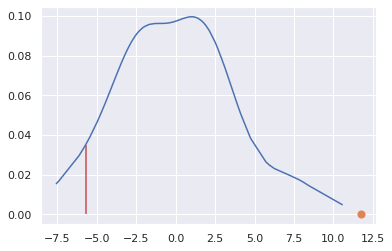

In [395]:
plt.plot(X_msft.msft_wkly_rtrn, X_msft.msft_prob, color='C0')
plt.vlines(eg_pct_change['msft_5ile'], ymin=0, ymax=eg_pct_change['msft_5ile_p'], colors='C3')
plt.scatter(eg_pct_change['MSFT'], 0, 50, marker='o', color='C1')
plt.show()

In [397]:
X.head()

,msft_wkly_rtrn,msft_prob,abbv_wkly_rtrn,abbv_prob,xom_wkly_rtrn,xom_prob,t_wkly_rtrn,t_prob,mmm_wkly_rtrn,mmm_prob
0,-7.576489,0.015489,-7.559084,0.010980,-14.274344,0.001912,-10.549323,0.002941,-10.147853,0.003445
1,-7.456671,0.016488,-7.230216,0.012704,-8.842982,0.009828,-6.916872,0.017956,-7.471488,0.014024
2,-7.403813,0.016935,-6.656621,0.015740,-8.716234,0.010241,-6.331567,0.024162,-6.977561,0.019007
3,-6.138975,0.029562,-6.186197,0.018517,-8.003444,0.012799,-5.261156,0.039429,-5.799927,0.032322
4,-6.112513,0.029882,-5.232588,0.026272,-7.359879,0.015597,-5.191858,0.040588,-5.673813,0.033668


In [398]:
X.tail()

,msft_wkly_rtrn,msft_prob,abbv_wkly_rtrn,abbv_prob,xom_wkly_rtrn,xom_prob,t_wkly_rtrn,t_prob,mmm_wkly_rtrn,mmm_prob
100,7.269610,0.019536,6.666681,0.018006,10.789572,0.016869,6.185252,0.025120,4.999593,0.028862
101,7.827632,0.017458,6.802641,0.016931,11.277271,0.014875,7.170505,0.018284,5.221323,0.025199
102,8.096115,0.016245,6.951517,0.015831,11.311450,0.014738,8.070189,0.013153,5.682656,0.019105
103,8.440157,0.014507,9.173590,0.006988,11.628116,0.013483,8.307536,0.011958,6.799881,0.010444
104,10.562915,0.004914,10.167764,0.005319,15.246621,0.003439,14.076042,0.001816,8.381167,0.004993


In [399]:
X.to_csv('bc5_pdistribution_20201026-20221107.txt', sep=' ', index=False)

In [401]:
eg_pct_change_df = pd.DataFrame(eg_pct_change, index=[0])

In [403]:
eg_pct_change_df.to_csv('eg_pct_change_5tile_threshold.txt', index=False, sep=' ')

## Enhancing DCA by prioritizing rare price drops

In [ ]:
bc5.index.Date.index[bc5.index.Date==eg_pct_change['Date']]

In [408]:
simulated_dates = bc5.index.Date.iloc[106:]

In [438]:
final_date = simulated_dates.iloc[-1]

In [409]:
simulated_dates.head()

106    2022-11-07
107    2022-11-14
108    2022-11-21
109    2022-11-28
110    2022-12-05
Name: Date, dtype: object

In [410]:
simulated_dates.tail()

203    2024-09-16
204    2024-09-23
205    2024-09-30
206    2024-10-07
207    2024-10-14
Name: Date, dtype: object

In [407]:
bc5.index.Date.index[bc5.index.Date==eg_pct_change['Date']]

Index([106], dtype='int64')

In [434]:
index_fund_investor = etk.Index_Fund(bc5, cash=500.0, cashflow=500.0)
index_fund_investor.set_cashflow_start(simulated_dates.iloc[0])

In [435]:
apd_investor = etk.Adaptive_Price_Drop(bc5, threshold=5.0, cash=500.0, cashflow=500.0)
apd_investor.set_cashflow_start(simulated_dates.iloc[0])
apd_investor.set_partial_shares(True)
# apd_investor.set_lag(104)  # Two years of price history

In [436]:
for d in simulated_dates:
    index_fund_investor.invest(d, partial_shares=True)
    apd_investor.apd_invest(d)

/home/drew/projects/portfolio_projects/stock_analytics/equities_value_simulator/equities_toolkit.py:347: RuntimeWarning: divide by zero encountered in scalar power
  
/home/drew/projects/portfolio_projects/stock_analytics/equities_value_simulator/equities_toolkit.py:352: RuntimeWarning: invalid value encountered in scalar divide
  if ndx < 30:
/home/drew/projects/portfolio_projects/stock_analytics/equities_value_simulator/equities_toolkit.py:347: RuntimeWarning: divide by zero encountered in scalar power
  
/home/drew/projects/portfolio_projects/stock_analytics/equities_value_simulator/equities_toolkit.py:352: RuntimeWarning: invalid value encountered in scalar divide
  if ndx < 30:


In [437]:
apd_investor.purchases

[{'Date': datetime.date(2022, 11, 7),
  'MSFT': (1.5210885048078993, 242.92),
  'ABBV': (0.2848161551967824, 139.24),
  'XOM': (0.5947727614943638, 106.57),
  'T': (1.107982124633342, 16.81),
  'MMM': (0.08764693750087112, 100.7),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2022, 11, 14), 'Action': 'Price Out'},
 {'Date': datetime.date(2022, 11, 21),
  'MSFT': (1.514484765317378, 243.98),
  'ABBV': (0.2679362703211667, 148.01),
  'XOM': (0.593879718173335, 106.73),
  'T': (1.1039256499534382, 16.87),
  'MMM': (0.08927770162289969, 98.86),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2022, 11, 28), 'Action': 'Price Out'},
 {'Date': datetime.date(2022, 12, 5),
  'MSFT': (1.5272588806974219, 241.94),
  'ABBV': (0.2622837511705835, 151.2),
  'XOM': (0.6493444239342293, 97.61),
  'T': (1.10566046056147, 16.85),
  'MMM': (0.09160619296028928, 96.34),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2022, 12, 12), 'Action': 'Price Out'},
 {'Date': datetime.date(2022, 12, 19),
  'M

In [440]:
apd_purchases_df = pd.DataFrame(apd_investor.purchases)

In [441]:
apd_purchases_df.head()

,Date,MSFT,ABBV,XOM,T,MMM,Action
0,2022-11-07,"(1.5210885048078993, 242.92)","(0.2848161551967824, 139.24)","(0.5947727614943638, 106.57)","(1.107982124633342, 16.81)","(0.08764693750087112, 100.7)",Buy Index
1,2022-11-14,NaN,NaN,NaN,NaN,NaN,Price Out
2,2022-11-21,"(1.514484765317378, 243.98)","(0.2679362703211667, 148.01)","(0.593879718173335, 106.73)","(1.1039256499534382, 16.87)","(0.08927770162289969, 98.86)",Buy Index
3,2022-11-28,NaN,NaN,NaN,NaN,NaN,Price Out
4,2022-12-05,"(1.5272588806974219, 241.94)","(0.2622837511705835, 151.2)","(0.6493444239342293, 97.61)","(1.10566046056147, 16.85)","(0.09160619296028928, 96.34)",Buy Index


In [442]:
apd_purchases_df_clean = apd_purchases_df.dropna()

In [443]:
apd_purchases_df_clean.head()

,Date,MSFT,ABBV,XOM,T,MMM,Action
0,2022-11-07,"(1.5210885048078993, 242.92)","(0.2848161551967824, 139.24)","(0.5947727614943638, 106.57)","(1.107982124633342, 16.81)","(0.08764693750087112, 100.7)",Buy Index
2,2022-11-21,"(1.514484765317378, 243.98)","(0.2679362703211667, 148.01)","(0.593879718173335, 106.73)","(1.1039256499534382, 16.87)","(0.08927770162289969, 98.86)",Buy Index
4,2022-12-05,"(1.5272588806974219, 241.94)","(0.2622837511705835, 151.2)","(0.6493444239342293, 97.61)","(1.10566046056147, 16.85)","(0.09160619296028928, 96.34)",Buy Index
6,2022-12-19,"(1.5700575764472204, 235.35)","(0.2622194475110538, 151.24)","(0.6186338381486788, 102.46)","(1.1527615658473889, 16.16)","(0.0958914170063212, 92.04)",Buy Index
8,2023-01-02,"(1.9302277371672527, 221.74)","(0.10139339138607746, 154.44)","(0.3080559070035233, 104.2)","(0.7096017007543208, 17.23)","(0.12361346323676942, 97.08)",Buy APD


In [458]:
def split_shares_prices(df, columns):
    df = df.copy()
    for col in columns:
        col_name = col+'_shares'
        df[col_name] = df[col].apply(lambda x: x[0])
        col_name = col+'_price'
        df[col_name] = df[col].apply(lambda x: x[1])
        df = df.drop(columns=col)
    return(df)

In [504]:
def calc_cost_gains(df, columns, prices):
    cost_df = pd.DataFrame()
    for col in columns:
        col_name = col+'_cost'
        cost_df[col_name] = df[col].apply(lambda x: x[0]*x[1])
        col_name = col+'_gl'
        cost_df[col_name] = df[col].apply(lambda x: x[0]*prices[col] - x[0]*x[1])
    return(cost_df)

In [465]:
apd_purchases_df_clean = split_shares_prices(apd_purchases_df_clean, tickers)

In [470]:
if_purchases_df = pd.DataFrame(index_fund_investor.purchases)
if_purchases_df_clean = if_purchases_df.dropna()
if_purchases_df_clean = split_shares_prices(if_purchases_df_clean, tickers)

In [518]:
if_purchases_df_clean.head()

,Date,Action,MSFT_shares,MSFT_price,ABBV_shares,ABBV_price,XOM_shares,XOM_price,T_shares,T_price,MMM_shares,MMM_price
0,2022-11-07,Buy Index,1.521089,242.92,0.284816,139.24,0.594773,106.57,1.107982,16.81,0.087647,100.70
2,2022-11-21,Buy Index,1.514485,243.98,0.267936,148.01,0.593880,106.73,1.103926,16.87,0.089278,98.86
4,2022-12-05,Buy Index,1.527259,241.94,0.262284,151.20,0.649344,97.61,1.105660,16.85,0.091606,96.34
6,2022-12-19,Buy Index,1.570058,235.35,0.262219,151.24,0.618634,102.46,1.152762,16.16,0.095891,92.04
8,2023-01-02,Buy Index,1.666384,221.74,0.256788,154.44,0.608279,104.20,1.080751,17.23,0.090912,97.08


In [519]:
if_purchases_df_clean.to_csv('if_purchases_cleaned.txt', index_label='week', sep=' ')

In [520]:
apd_purchases_df_clean.head()

,Date,Action,MSFT_shares,MSFT_price,ABBV_shares,ABBV_price,XOM_shares,XOM_price,T_shares,T_price,MMM_shares,MMM_price
0,2022-11-07,Buy Index,1.521089,242.92,0.284816,139.24,0.594773,106.57,1.107982,16.81,0.087647,100.70
2,2022-11-21,Buy Index,1.514485,243.98,0.267936,148.01,0.593880,106.73,1.103926,16.87,0.089278,98.86
4,2022-12-05,Buy Index,1.527259,241.94,0.262284,151.20,0.649344,97.61,1.105660,16.85,0.091606,96.34
6,2022-12-19,Buy Index,1.570058,235.35,0.262219,151.24,0.618634,102.46,1.152762,16.16,0.095891,92.04
8,2023-01-02,Buy APD,1.930228,221.74,0.101393,154.44,0.308056,104.20,0.709602,17.23,0.123613,97.08


In [521]:
apd_purchases_df_clean.to_csv('apd_purchases_cleaned.txt', index_label='week', sep=' ')

In [464]:
apd_purchases_df_clean.Action.value_counts()

Action
Buy Index    42
Buy APD       9
Name: count, dtype: int64

In [483]:
if_avg_std = {}
apd_avg_std = {}

In [485]:
if_avg_std['msft_avg'], if_avg_std['msft_std'] = weighted_avg_and_std(if_purchases_df_clean.MSFT_price, if_purchases_df_clean.MSFT_shares)
if_avg_std['abbv_avg'], if_avg_std['abbv_std'] = weighted_avg_and_std(if_purchases_df_clean.ABBV_price, if_purchases_df_clean.ABBV_shares)
if_avg_std['xom_avg'], if_avg_std['xom_std'] = weighted_avg_and_std(if_purchases_df_clean.XOM_price, if_purchases_df_clean.XOM_shares)
if_avg_std['t_avg'], if_avg_std['t_std'] = weighted_avg_and_std(if_purchases_df_clean.T_price, if_purchases_df_clean.T_shares)
if_avg_std['mmm_avg'], if_avg_std['mmm_std'] = weighted_avg_and_std(if_purchases_df_clean.MMM_price, if_purchases_df_clean.MMM_shares)


In [486]:
apd_avg_std['msft_avg'], apd_avg_std['msft_std'] = weighted_avg_and_std(apd_purchases_df_clean.MSFT_price, apd_purchases_df_clean.MSFT_shares)
apd_avg_std['abbv_avg'], apd_avg_std['abbv_std'] = weighted_avg_and_std(apd_purchases_df_clean.ABBV_price, apd_purchases_df_clean.ABBV_shares)
apd_avg_std['xom_avg'], apd_avg_std['xom_std'] = weighted_avg_and_std(apd_purchases_df_clean.XOM_price, apd_purchases_df_clean.XOM_shares)
apd_avg_std['t_avg'], apd_avg_std['t_std'] = weighted_avg_and_std(apd_purchases_df_clean.T_price, apd_purchases_df_clean.T_shares)
apd_avg_std['mmm_avg'], apd_avg_std['mmm_std'] = weighted_avg_and_std(apd_purchases_df_clean.MMM_price, apd_purchases_df_clean.MMM_shares)


In [487]:
avg_std = pd.DataFrame([if_avg_std, apd_avg_std], index=['if', 'apd'])

In [488]:
avg_std

,msft_avg,msft_std,abbv_avg,abbv_std,xom_avg,xom_std,t_avg,t_std,mmm_avg,mmm_std
if,334.979454,69.701788,152.147751,17.846774,106.467824,6.907012,16.189348,2.001696,88.645479,15.268496
apd,339.097114,70.117378,149.551351,16.344348,105.148647,7.177537,15.618926,1.755587,88.965960,10.213364


In [489]:
avg_std.to_csv('dca_strategy_avg_std.txt', index_label='strategy', sep=' ')

In [498]:
X_if = if_purchases_df.dropna().drop(columns=['Action'])

In [499]:
X_apd = apd_purchases_df.dropna().drop(columns=['Action'])

In [496]:
X_if.head()

,MSFT,ABBV,XOM,T,MMM
0,"(1.5210885048078993, 242.92)","(0.2848161551967824, 139.24)","(0.5947727614943638, 106.57)","(1.107982124633342, 16.81)","(0.08764693750087112, 100.7)"
2,"(1.514484765317378, 243.98)","(0.2679362703211667, 148.01)","(0.593879718173335, 106.73)","(1.1039256499534382, 16.87)","(0.08927770162289969, 98.86)"
4,"(1.5272588806974219, 241.94)","(0.2622837511705835, 151.2)","(0.6493444239342293, 97.61)","(1.10566046056147, 16.85)","(0.09160619296028928, 96.34)"
6,"(1.5700575764472204, 235.35)","(0.2622194475110538, 151.24)","(0.6186338381486788, 102.46)","(1.1527615658473889, 16.16)","(0.0958914170063212, 92.04)"
8,"(1.666384480611656, 221.74)","(0.2567877003851033, 154.44)","(0.6082793990023653, 104.2)","(1.080750680369371, 17.23)","(0.09091220528648665, 97.08)"


In [491]:
final_date

datetime.date(2024, 10, 14)

In [493]:
final_prices = bc5.get_prices(final_date)
final_prices

{'MSFT': 418.1600036621094,
 'ABBV': 188.86000061035156,
 'XOM': 120.01000213623047,
 'T': 21.850000381469727,
 'MMM': 135.13999938964844}

In [505]:
if_cost_gain = calc_cost_gains(X_if, tickers, final_prices)

In [506]:
if_cost_gain.head()

,MSFT_cost,MSFT_gl,ABBV_cost,ABBV_gl,XOM_cost,XOM_gl,T_cost,T_gl,MMM_cost,MMM_gl
0,369.502820,266.555555,39.657801,14.132578,63.384933,7.993747,18.625180,5.584230,8.826047,3.018560
2,369.503993,263.792962,39.657247,10.945197,63.384782,7.886724,18.623226,5.497550,8.825994,3.238995
4,369.505014,269.133566,39.657303,9.877606,63.382509,14.545316,18.630379,5.528303,8.825341,3.554320
6,369.513051,287.022231,39.658069,9.864696,63.385223,10.857025,18.628627,6.559214,8.825846,4.132920
8,369.504095,327.311246,39.658292,8.838633,63.382713,9.616899,18.621334,4.993069,8.825757,3.460118


In [507]:
apd_cost_gain = calc_cost_gains(X_apd, tickers, final_prices)

In [509]:
apd_cost_gain.head()

,MSFT_cost,MSFT_gl,ABBV_cost,ABBV_gl,XOM_cost,XOM_gl,T_cost,T_gl,MMM_cost,MMM_gl
0,369.502820,266.555555,39.657801,14.132578,63.384933,7.993747,18.625180,5.584230,8.826047,3.018560
2,369.503993,263.792962,39.657247,10.945197,63.384782,7.886724,18.623226,5.497550,8.825994,3.238995
4,369.505014,269.133566,39.657303,9.877606,63.382509,14.545316,18.630379,5.528303,8.825341,3.554320
6,369.513051,287.022231,39.658069,9.864696,63.385223,10.857025,18.628627,6.559214,8.825846,4.132920
8,428.008698,379.135339,15.659195,3.489961,32.099426,4.870365,12.226437,3.278360,12.000395,4.704728


In [513]:
gl = [if_cost_gain.apply(np.sum, axis=0).to_dict(), apd_cost_gain.apply(np.sum, axis=0).to_dict()]

In [515]:
gl = pd.DataFrame(gl, index=['if', 'apd'])

In [516]:
gl

,MSFT_cost,MSFT_gl,ABBV_cost,ABBV_gl,XOM_cost,XOM_gl,T_cost,T_gl,MMM_cost,MMM_gl
if,18844.800229,4679.453683,2022.540375,488.025658,3232.664737,411.178887,949.848498,332.117241,450.109893,236.082466
apd,16141.831781,3763.582214,2793.202523,734.176042,3655.230904,516.618024,1623.667345,647.752038,1286.038456,667.464172


In [517]:
gl = pd.DataFrame(gl, index=['if', 'apd'])
gl.to_csv('dca_strategy_gains.txt', index_label='strategy', sep=' ')